In [1]:
import pandas as pd
from nilearn import image, plotting, masking
from scipy import ndimage 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import glob

/Users/gilles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
layers_left = image.load_img('/data/odc/derivatives/nighres/layers/sub-tk_left_cruise_gwb_layering_depth.nii.gz')
layers_right = image.load_img('/data/odc/derivatives/nighres/layers/sub-tk_right_cruise_gwb_layering_depth.nii.gz')
layers = image.math_img('layers_l + layers_r', layers_l=layers_left, layers_r=layers_right)

In [3]:
ref = image.load_img('/data/odc/derivatives/spynoza/sub-tk/ses-odc2/func/sub-tk_ses-odc2_task-checkerboard_acq-07_run-02_bold_reference.*')

layers_bold = image.resample_to_img(layers, ref, interpolation='nearest')
layers_bold.to_filename('/data/odc/zooi/depth_bold.nii.gz')

image.resample_to_img('/data/odc/zooi/V1.rh.nii.gz', ref, 'nearest').to_filename('/data/odc/zooi/V1.rh.bold.nii.gz')
image.resample_to_img('/data/odc/zooi/V1.lh.nii.gz', ref, 'nearest').to_filename('/data/odc/zooi/V1.lh.bold.nii.gz')

v1 = image.math_img('v1_lh + v1_rh', v1_lh='/data/odc/zooi/V1.lh.bold.nii.gz', v1_rh='/data/odc/zooi/V1.rh.bold.nii.gz')

v1 = image.new_img_like(ref, ndimage.binary_dilation(v1.get_data(), iterations=2))
mask = image.math_img('(v1 > 0) & (depth > 0)', v1=v1, depth=layers_bold)

In [4]:
import re
import pandas as pd

In [5]:
preprocs = glob.glob('/data/odc/derivatives/spynoza/sub-tk/ses-odc2/func/sub-tk_ses-odc2_task-*_acq-07_run-*_bold_*.*')

reg = re.compile('.*/sub-tk_ses-odc2_task-(?P<task>[a-z]+)_acq-07_run-(?P<run>[0-9]+)_bold_(?P<type>.+)\.(nii\.gz|tsv|svg)')

df = []
for pp in preprocs:
    d = reg.match(pp).groupdict()
    d['fn'] = pp
    df.append(d)

df = pd.DataFrame(df)
df = df[np.in1d(df.type, ['preproc', 'preproc_confounds_compcor', 'confounds'])].pivot(index='run', columns='type').drop(columns=[('task', 'confounds'), ('task', 'preproc')])

In [7]:
from nilearn.input_data import NiftiMasker

In [8]:
masker = NiftiMasker(v1, t_r=4, high_pass=1/128.)

In [9]:
from sklearn.decomposition import PCA

In [104]:
ts = []

pca = PCA(n_components=6)

for ix, row in df.iterrows():
    print(ix)
    confounds = pd.concat((pd.read_table(row['fn', 'confounds']), pd.read_table(row['fn', 'preproc_confounds_compcor'])), 1).fillna(method='bfill')
    confounds = pca.fit_transform(confounds)

    t = pd.DataFrame(masker.fit_transform(row['fn', 'preproc'], confounds=confounds))
    t.columns = pd.MultiIndex.from_product([[ix], t.columns], names=['run', 'voxel'])
    t.index = t.index.set_names('frame')
    
    ts.append(t)
    
ts = pd.concat(ts, 1)

01
02
03
04
05
06
07
08
09
10


In [105]:
ts.head()

run           01                                                         \
voxel      0          1          2          3          4          5       
frame                                                                     
0      -0.265885   1.450522   1.474013   0.005040   1.867034   0.112411   
1     -15.283939 -10.505587 -18.415476  -1.593814 -18.338962   5.882021   
2      -3.582529 -18.563601  -9.161148   0.110370 -36.185973   4.124906   
3     -16.766670   1.117174   8.451984 -13.989087  -5.300199 -10.996834   
4      -9.065444  -2.192789 -13.626728  10.569483 -21.440639   1.688817   

run                                                ...             10  \
voxel     6          7         8          9        ...          49365   
frame                                              ...                  
0      0.834314   0.521730 -0.082578  -0.061975    ...      -3.033223   
1     -8.233284 -11.691711 -0.975433  -2.520736    ...     -11.981820   
2     -1.318856  -9.866282 -1.596596 -11.684828    ...      81.603089   
3     -0.124900   2.713865 -1.623439   3.730767    ...       8.838860   
4     -9.332188   1.468057  1.809148   2.588621    ...      58.616684   

run                                                                     \
voxel      49366      49367      49368     49369      49370      49371   
frame                                                                    
0      -2.307987  -0.254286  -0.822392  0.036038  -0.665591  -0.403532   
1     -39.565418 -24.215161 -14.487127 -1.610196   5.271633  12.550305   
2      78.210683   6.871647  -2.929478  2.837608  10.918910  19.389061   
3       8.490057 -17.497701  -9.596606 -5.989458  68.982902   7.866922   
4      79.954817  18.352454   8.525070  3.695078  52.766314   2.781938   

run                                    
voxel     49372      49373      49374  
frame                                  
0     -0.024048  -0.234367  -0.591641  
1     -1.280129   5.491672 -18.033053  
2     -6.472076   9.889759  -1.935454  
3      2.521872  11.187482  -5.660976  
4      5.302504   9.850830  13.833142  

[5 rows x 493750 columns]

In [106]:
mean_ts = ts.groupby(level='voxel', axis=1).mean()

masker.inverse_transform(mean_ts).to_filename('/data/odc/zooi/mean_ts.nii.gz')

# Dot product z-map

In [107]:
from sklearn.model_selection import KFold

In [108]:
kfold = KFold(n_splits=5)

In [109]:
from nilearn.masking import apply_mask

In [118]:
tmp = []

for i, (train, test) in enumerate(kfold.split(df)):
    print(i)
    print(train)
    print(test)
    z = image.load_img('/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/cv/sub-tk_ses-odc2_cv-{}_left_over_right_zmap.nii.gz'.format(i+1))
    z = apply_mask(z, v1)
    
    z /= np.abs(z).sum()
    
    tmp.append(ts[['%02d' % (i+1) for i in test]].groupby(axis=1, level='run').apply(lambda d, z: d.dot(z), z))

0
[2 3 4 5 6 7 8 9]
[0 1]
1
[0 1 4 5 6 7 8 9]
[2 3]
2
[0 1 2 3 6 7 8 9]
[4 5]
3
[0 1 2 3 4 5 8 9]
[6 7]
4
[0 1 2 3 4 5 6 7]
[8 9]


In [119]:
proj_ts = pd.concat(tmp, 1)

In [120]:
tmp = proj_ts.reset_index().melt(id_vars='frame')

tmp['task'] = tmp.run.map(lambda d: {0:'checkerboard', 1:'fixation'}[int(d) % 2])

In [121]:
sns.set_context('poster')

In [131]:
tmp['time (s)'] = tmp['frame'] * 4

In [133]:
sns.set_style('whitegrid')

/Users/gilles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


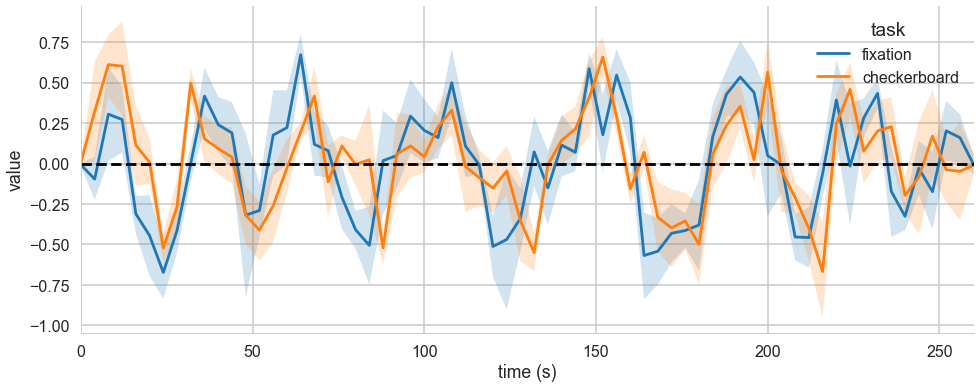

In [134]:
sns.tsplot(tmp, time='time (s)', unit='run', value='value', condition='task')
plt.gcf().set_size_inches(16, 6)
sns.despine()
plt.axhline(0, c='k', ls='--')
plt.savefig('projected_ts.pdf')

/Users/gilles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


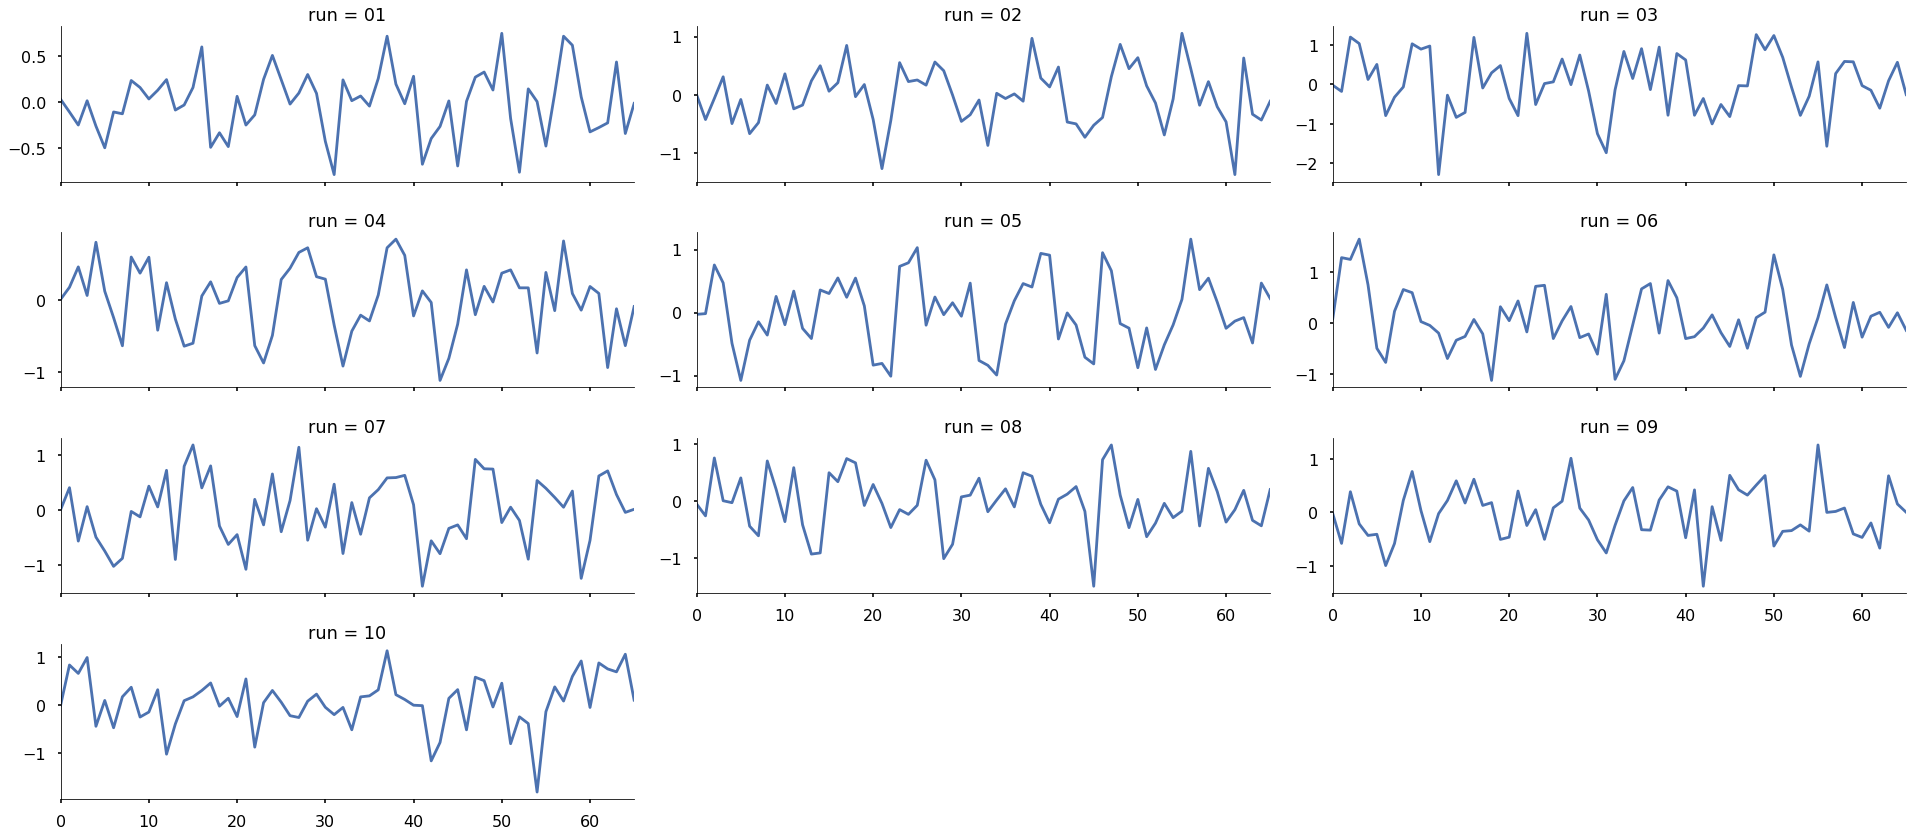

In [126]:

fac = sns.FacetGrid(tmp, col='run', col_wrap=3, sharey=False, aspect=3)
fac.map_dataframe(sns.tsplot, time='frame', value='value', color='deep', unit='run', )

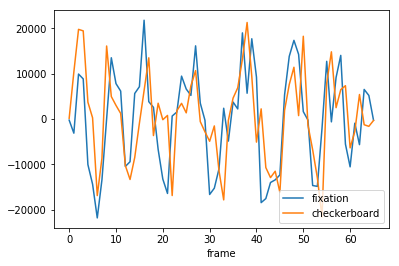

In [83]:
ts.iloc[:, ::2].mean(1).plot(label='fixation')
ts.iloc[:, 1::2].mean(1).plot(label='checkerboard')
plt.legend()

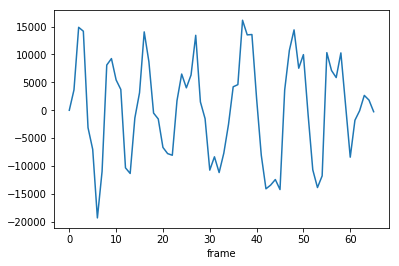

In [75]:
ts.mean(1).plot()